In [1]:
import pandas as pd
import numpy as np
import scipy
import matplotlib
import sklearn
import math
import seaborn as sns
color = sns.color_palette()
from sklearn import preprocessing#, preprocessing
from matplotlib import pyplot as plt
from matplotlib import pylab as plb
from matplotlib import cm as cm
%matplotlib inline

# Векторизация

Хорошей идеей для дозаполнения данных будет научиться строить вектор соответствующий конкретной квартире. Тогда по углу между векторами можно будет судить о сходстве\различии квартир, и на основе этого сходства можно будет предсказать незаполненные параметры.
Итак, простейший способ - построить линейную модель над нормированными параметрами. Тогда мы автоматически представим каждую квартиру в n-мерном пространстве, где n-количество выбранных параметров, как вектор.
Исследовать вопрос о переобучении. Скорее всего оно будет, из-за влияния статистики.

In [2]:
train = pd.read_csv("train.csv", encoding= "utf_8")
test = pd.read_csv("test.csv", encoding= "utf_8")
train.head()

,id,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,...,cafe_count_5000_price_2500,cafe_count_5000_price_4000,cafe_count_5000_price_high,big_church_count_5000,church_count_5000,mosque_count_5000,leisure_count_5000,sport_count_5000,market_count_5000,price_doc
0,1,2011-08-20,43,27.0,4.0,NaN,NaN,NaN,NaN,NaN,...,9,4,0,13,22,1,0,52,4,5850000
1,2,2011-08-23,34,19.0,3.0,NaN,NaN,NaN,NaN,NaN,...,15,3,0,15,29,1,10,66,14,6000000
2,3,2011-08-27,43,29.0,2.0,NaN,NaN,NaN,NaN,NaN,...,10,3,0,11,27,0,4,67,10,5700000
3,4,2011-09-01,89,50.0,9.0,NaN,NaN,NaN,NaN,NaN,...,11,2,1,4,4,0,0,26,3,13100000
4,5,2011-09-05,77,77.0,4.0,NaN,NaN,NaN,NaN,NaN,...,319,108,17,135,236,2,91,195,14,16331452


Введём пространство признаков, в котором будем строить вектор квартиры. Будем считать, что признаки влияют в равной степени, хотя это и не обязательно.

In [3]:
basis = ["price_doc", "full_sq", "life_sq",
"floor", "max_floor", "material", "build_year", "num_room",
"kitch_sq", "state"]

Нормировать будем на среднее либо моду, чтобы выбросы оказали меньше влияния на вид результата Нужно придумать правила для build_year

In [4]:
data = train[basis]
data.head(3)

,price_doc,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state
0,5850000,43,27.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN
1,6000000,34,19.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN
2,5700000,43,29.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN


## Очистка NaN

Как видим, в данных очень много NaN. При сравнении они будут нам мешать, поэтому заменим их на median / mode по столбцу, в зависимости от того, категориальный признак или целочисленный.

In [5]:
def modifyNans(columns, dataset, isEnumeral):
    for j in columns:
        if(isEnumeral == TRUE):
            train.loc[train[j].isnull(),j]=train.loc[train[j].notnull(),j].median()
        if(isEnumeral == False): 
            dataset.loc[(dataset[column].isnull()), column] = dataset.loc[(dataset[column].notnull()), column].median()

Часть переменных можно представить в виде значений с плавающей точкой. Для них нормировку будем производить по медианному значению.
Корелляция

In [6]:
basis_float = ["price_doc", "full_sq", "life_sq","kitch_sq", "build_year"]
for j in basis_float:
    data.loc[data[j].isnull(),j]=data.loc[train[j].notnull(),j].median()
data[basis_float].head(3)

D:\Coding\conda\lib\site-packages\pandas\core\indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
D:\Coding\conda\lib\site-packages\pandas\core\indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
D:\Coding\conda\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so w

,price_doc,full_sq,life_sq,kitch_sq,build_year
0,5850000.0,43.0,27.0,6.0,1979.0
1,6000000.0,34.0,19.0,6.0,1979.0
2,5700000.0,43.0,29.0,6.0,1979.0


In [7]:
basis_int = ["floor", "max_floor", "material", "num_room", "state"]
for j in basis_int:
    data.loc[data[j].isnull(),j]=data.loc[train[j].notnull(),j].median()
data.head(3)

D:\Coding\conda\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,price_doc,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state
0,5850000.0,43.0,27.0,4.0,12.0,1.0,1979.0,2.0,6.0,2.0
1,6000000.0,34.0,19.0,3.0,12.0,1.0,1979.0,2.0,6.0,2.0
2,5700000.0,43.0,29.0,2.0,12.0,1.0,1979.0,2.0,6.0,2.0


Есть переменные, которые с высокой долей вероятности говорят о том, что квартиры находятся в одном доме.

//Нормируем вектора, чтобы декартово рacстояние имело смысл.

In [8]:
data_normed=data
for elem in basis:
    data_normed[elem] = data[elem] / data.loc[data[elem].notnull(),elem].median()
#     data_normed.loc[data_normed[elem].isnull(),elem]=data_normed.loc[data_normed[elem].notnull(),elem].median()
data_normed.head()

D:\Coding\conda\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,price_doc,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state
0,0.932358,0.877551,0.900000,0.615385,1.0,1.0,1.0,1.0,1.0,1.0
1,0.956265,0.693878,0.633333,0.461538,1.0,1.0,1.0,1.0,1.0,1.0
2,0.908452,0.877551,0.966667,0.307692,1.0,1.0,1.0,1.0,1.0,1.0
3,2.087845,1.816327,1.666667,1.384615,1.0,1.0,1.0,1.0,1.0,1.0
4,2.602866,1.571429,2.566667,0.615385,1.0,1.0,1.0,1.0,1.0,1.0


Наивным предположением будет предположение о том, что все координаты равносильны, и каждую при рассчёте вектора нужно брать с коэффициентом 1. Тогда по-сути вектор - это сумма значений, умноженных на соответствующие базисные вектора. В таком случае в качестве длины вектора можно рассматривать корень из суммы квадратов координат, а в качестве расстояния - косинусное расстояние между векторами либо, в силу нормированности векторов, декартово расстояние.

Будем использовать косинусное расстояние.

In [9]:
def findLength(row):
    length = 0
    for a in row:
        if(np.isnan(a)==False):
            length += np.square(a)
    return np.sqrt(length)

In [10]:
print data.iloc[0]
print findLength(data.iloc[0])

price_doc     0.932358
full_sq       0.877551
life_sq       0.900000
floor         0.615385
max_floor     1.000000
material      1.000000
build_year    1.000000
num_room      1.000000
kitch_sq      1.000000
state         1.000000
Name: 0, dtype: float64
2.971209562365576


In [11]:
def findDiff(vec1, vec2):
    resultSquared = 0.0
    columns = vec1.axes[0]
    columns2 = vec2.axes[0]
    if(len(columns) != len(columns2)):
        return -1
    for columnName in columns:
        #if(np.isnan(vec1[columnName]) == False & np.isnan(vec2[columnName]) == False):
          if(columnName != 'build_year'):
            resultSquared+=np.square(vec1[columnName] - vec2[columnName])
    return np.sqrt(resultSquared)

In [12]:
lengths = []
i=900
for index, row in data.iterrows():
    lengths.append(findLength(row))
lengths = np.sort(lengths)
lengths = lengths[0:30100]
print np.max(lengths)

7.87890872740389


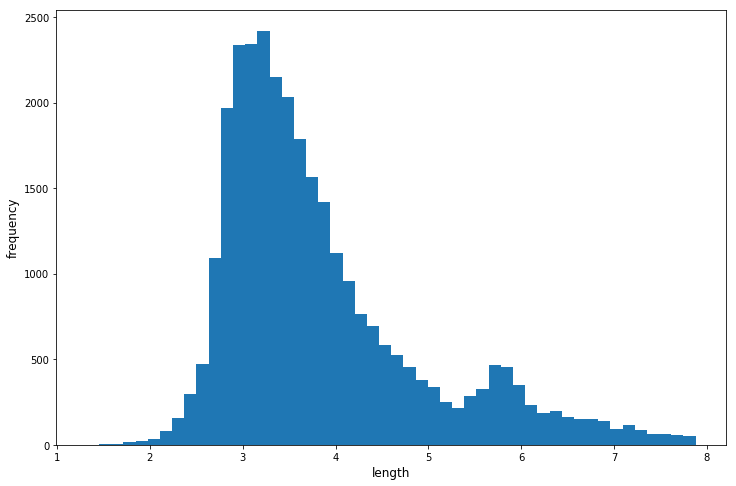

In [13]:
plt.figure(figsize=(12,8))
plt.hist(lengths, bins=50)
plt.ylabel('frequency', fontsize=12)
plt.xlabel('length', fontsize=12)
plt.show()

Построить гистограмму длин векторов, разобраться, что за странные выбросы присутствуют:

## Косинусное расстояние

In [14]:
train = pd.read_csv("train.csv", encoding= "utf_8")
test = pd.read_csv("test.csv", encoding= "utf_8")

In [15]:
basis = ["price_doc", "full_sq", "life_sq",
"floor", "max_floor", "material", "build_year", "num_room",
"kitch_sq", "state"]

In [16]:
data = train[basis]

In [17]:
data.head(2)

,price_doc,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state
0,5850000,43,27.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN
1,6000000,34,19.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN


В недрах scipy была найдена функция
scipy.spatial.distance.cosine, 
которая возвращает косинусное расстояние между двумя одномерными массивами.
На основании неё была создана функция, измеряющая косинусное расстояние между векторами.

Возвращаясь к вопросу о векторизации, разные параметры имеют разное влияние на цену недвижимости. Уточним нулевую гипотезу о влиянии различных параметров на косинусное расстояние: пусть каждая переменная входит в итоговую формулу с весом, равным её корреляции со стоимостью квартиры.

In [18]:
corr = data.corr()
corr["price_doc"]["price_doc"]

1.0

In [19]:
def findCosineDiff(vec1, vec2):
    resultSquared = 0.0
    vec1Array = np.array([])
    vec2Array = np.array([])
    columns = vec1.axes[0]
    columns2 = vec2.axes[0]
    if(len(columns) != len(columns2)):
        return -1
    for columnName in columns:
        if(columnName != 'price_doc'):
            result1 = vec1[columnName]
            result2 = vec2[columnName]
            if(np.isfinite(result1) == True and np.isfinite(result2) == True):
                vec1Array = np.append(vec1Array, result1*corr[columnName]['price_doc'])
                vec2Array = np.append(vec2Array, result2*corr[columnName]['price_doc'])
#     print vec1Array
#     print vec2Array
    return scipy.spatial.distance.cosine(vec1Array, vec2Array)

In [20]:
print data.iloc[0]
print " "
print data.iloc[178]
findCosineDiff(data.iloc[0], data.iloc[178])

price_doc     5850000.0
full_sq            43.0
life_sq            27.0
floor               4.0
max_floor           NaN
material            NaN
build_year          NaN
num_room            NaN
kitch_sq            NaN
state               NaN
Name: 0, dtype: float64
 
price_doc     11500000.0
full_sq             98.0
life_sq             94.0
floor                NaN
max_floor            NaN
material             NaN
build_year           NaN
num_room             NaN
kitch_sq             NaN
state                NaN
Name: 178, dtype: float64


0.009741707859396653

Построим гисторамму косинусного расстояния

In [ ]:
def plotHist(data):
#     np.histogram(data, bins=100)
    plt.figure(figsize=(12,8))
    plt.hist(data, bins=30)
    plt.ylabel('frequency', fontsize=12)
    plt.xlabel('cosine diff', fontsize=12)
    plt.show()

In [ ]:
lengths = np.array([])
for i in range(0, 1):
    for index, row in data.iterrows():
        a = (findCosineDiff(data.iloc[i], row))
        if(np.isfinite(a) == True and np.isnan(a) == False):
            lengths = np.append(lengths, a)

In [ ]:
lengths = np.sort(lengths)
lengths = lengths[0:25000]
print np.median(lengths)
plotHist(lengths)

## Дозаполнение

Будем считать походими вектора с мерой сходства порядка 10^-3
Отобразим пару "похожих" векторов.

In [ ]:
print data.iloc[0]
print "row 0"
for index, row in data.iterrows():
#     12423
        a = (findCosineDiff(data.iloc[0], row))
        if(a < 0.0000001 and index > 1):
            print " "
            print "row"+str(index)
            print row
#             break

Как видим, например, посредством 10962 можно дозаполнить 0:

In [ ]:
print data.iloc[0]
print " "
print data.iloc[10962]

In [ ]:
def fill(fromElemIndex, toElemIndex, dataset):
    fromElem = dataset.iloc[fromElemIndex]
    toElem = dataset.iloc[toElemIndex]
    columns = fromElem.axes[0]
    for columnName in columns:
        if(np.isnan(toElem[columnName]) == True and np.isnan(fromElem[columnName]) == False):
            print columnName
            print "from "+str(fromElem[columnName])+" to "+str(toElem[columnName])
            dataset.ix[toElemIndex, columnName] = dataset.ix[fromElemIndex, columnName]

In [ ]:
fill(10962, 0, data)

In [ ]:
print data.iloc[0]
print " "
print data.iloc[25181]

Напишем функцию, которая будет заполнять средним по множеству похожих элементов значением:
Предполагаем, что на рынке нет "безумных" предложений. Будем дозаполнять теми, цена на которые отличается не более чем на 10%

In [ ]:
def collect(i, dataset):
    neighbors = np.array([])
    fromElem = dataset.iloc[i]
    for index, row in dataset.iterrows():
        a = (findCosineDiff(fromElem, row))
        if(a < 0.0000001 and index != i):
            neighbors = np.append(neighbors, index)
    return neighbors

In [ ]:
def reduceSet(i, dataset, indices, columnName):
    goodData = dataset.iloc[indices]
    goodData.head()
#     goodData = goodData.loc[np.logical_and(goodData['price_doc']/elem['price_doc'] > 0.8, goodData['price_doc']/elem['price_doc'] < 1.2)]
    elem = dataset.iloc[i]
    if(np.isnan(elem[columnName]) or np.isinf(elem[columnName])):
#         e = dataset.iloc[i]
#         dataset.loc[i, columnName]=goodData.loc[(goodData[columnName].notnull()),columnName].median()
#         print goodData.loc[(goodData[columnName].notnull()), columnName].median()
        dataset.loc[i, columnName]=goodData.loc[(goodData[columnName].notnull()), columnName].median()

In [ ]:
data.axes[1][0]

In [ ]:
def fill_by_neighbors(i, dataset):
    print "Collect phase"
    temp = collect(i, dataset)
    print len(temp)
    print "Reduce phase"
    for col in dataset.axes[1]:
        print col
        reduceSet(i, dataset, temp, col)
    print dataset.iloc[i]

In [ ]:
# print "Fill phase"
# temp2 = collect(2, data)

In [ ]:
# print temp2

In [ ]:
# elem = data.iloc[2]

In [ ]:
# elem

In [ ]:
# reduceSet(2, data, temp2, "max_floor")

In [ ]:
# print data.iloc[2]

In [ ]:
# print data.iloc[2]
# fill_by_neighbors(2, data)

In [ ]:
# print data.iloc[2]

In [ ]:
print data.iloc[4]

In [ ]:
fill_by_neighbors(4, data)

In [ ]:
print data.iloc[4]